In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import pickle
import lightgbm
import os
from lime import lime_tabular
import sys
sys.path.append('..')
from lirme_v2 import LIRME
from sklearn.utils import shuffle
from scipy.stats import spearmanr, kendalltau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
sys.path.append('..')
from get_exp_new import lime_exp, shap_exp, random_exp, grad_exp
from sklearn.metrics import ndcg_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sklearn.metrics import ndcg_score, jaccard_score

In [5]:
np.random.seed(10)

In [6]:
e_sample_sizes = [500, 1000, 1500, 2000, 3000, 4000, 5000]

In [7]:
def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 15, weight = 'bold', color = '0.2')

    return ax

In [8]:
DATASET_NAME = 'mq2008'

In [9]:
BASE_PATH = os.getcwd()
path = f'../data/'
background_dict = pickle.load( open( f"{path}/{DATASET_NAME}_background.p", "rb" ) )
test_sample = pickle.load( open( f"{path}/{DATASET_NAME}_test_sample.p", "rb" ) )

model_path = f'../models/lmart_{DATASET_NAME}_v2.txt'
ranker = lightgbm.Booster(model_file=f'{model_path}')

background = []
for q in background_dict:
    background.extend(background_dict[q])
background = np.array(background).reshape(-1, test_sample[list(test_sample.keys())[0]].shape[1])

lirme = LIRME(background)

In [17]:
def process_ax_v2(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 11, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 11, weight = 'bold', color = '0.2')

    return ax
    
def evaluate(exps_file):
    eval = {'dpff': {}, 'fidelity_ltr': {}, 'validity': {}, 'completeness': {}, 'infidelity': {}}
    exp_names = ['lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank']
    measure_keys = ['dpff', 'fidelity_ltr', 'validity', 'completeness', 'infidelity']
    
    for exp_name in exp_names:
        for m in measure_keys:
            eval[m][exp_name] = []
        
    for key in exps_file.keys():
        doc_values = background_dict[key]
        for exp_name in exps_file[key].keys():
            agg = []
            for i in range(len(exps_file[key][exp_name])):
                agg.append(exps_file[key][exp_name][i])
            exp_val = np.mean(agg, axis=0)
            
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['validity'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'validity'))
            eval['completeness'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'completeness'))
            eval['infidelity'][exp_name].append(get_infidelity(exp_val, doc_values, ranker.predict, background))
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['dpff'][exp_name].append(get_dpff(exp_val, doc_values, ranker))
    
    summary = summarize(eval)
    summary_df = pd.DataFrame(summary)
    summary_df = summary_df.reindex(columns=['dpff', 'fidelity_ltr', 'completeness', 'validity', 'infidelity'])
    
    return summary_df

def evaluate_listwise(exps_file):
    eval = {'dpff': {}, 'fidelity_ltr': {}, 'validity': {}, 'completeness': {}, 'infidelity': {}}
    exp_names = ['rank_lime']
    measure_keys = ['dpff', 'fidelity_ltr', 'validity', 'completeness', 'infidelity']
    
    for exp_name in exp_names:
        for m in measure_keys:
            eval[m][exp_name] = []
        
    for key in exps_file.keys():
        doc_values = background_dict[key]
        for exp_name in exps_file[key].keys():
            exp_val = exps_file[key][exp_name]
            
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['validity'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'validity'))
            eval['completeness'][exp_name].append(validity_completeness(exp_val, doc_values, ranker.predict, 'completeness'))
            eval['infidelity'][exp_name].append(get_infidelity(exp_val, doc_values, ranker.predict, background))
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, ranker.predict))
            eval['dpff'][exp_name].append(get_dpff(exp_val, doc_values, ranker))
    
    summary = summarize(eval)
    summary_df = pd.DataFrame(summary)
    summary_df = summary_df.reindex(columns=['dpff', 'fidelity_ltr', 'completeness', 'validity', 'infidelity'])
    
    return summary_df

In [10]:
def jaccard(first_exp, second_exp, top_k):    
    ranked_first = np.argsort(np.abs(first_exp))[-top_k:][::-1]
    ranked_second = np.argsort(np.abs(second_exp))[-top_k:][::-1]
    
    f_exp_1 = np.zeros(first_exp.shape[0])
    f_exp_1[ranked_first] = 1
    
    f_exp_2 = np.zeros(second_exp.shape[0])
    f_exp_2[ranked_second] = 1
    
    return jaccard_score(f_exp_1, f_exp_2, average='binary')

In [11]:
pointwise_exp = ['lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank']

color_list = {
    #'rank_lime': 'blue',
    'lirme': 'gold',
    'lime': 'darkorange',
    'shap': 'brown',
    'exs_top_k_rank': 'cyan', 
    'exs_top_k_binary': 'lightgreen', 
    'exs_score': 'magenta',
    'random': 'black',
    'pmi': 'turquoise',
    'greedy_score': 'blue',
    'rank_lime': 'green'
}

exp_names_figure = {
    'lime': 'LIME',
    'shap': 'SHAP',
    'lirme': 'LIRME',
    'exs_score': 'EXS (Score)',
    'exs_top_k_binary': 'EXS (Top-K Binary)',
    'exs_top_k_rank': 'EXS (Top-K Rank)'
}

In [12]:
e_sample_sizes = np.array([500, 1000, 1500, 2000, 3000, 4000, 5000])
listwise_sample_sizes = np.array([400, 500, 700, 1000, 1500, 2000, 3000])

DATASET_NAMES = ['mq2008', 'web10k', 'yahoo']

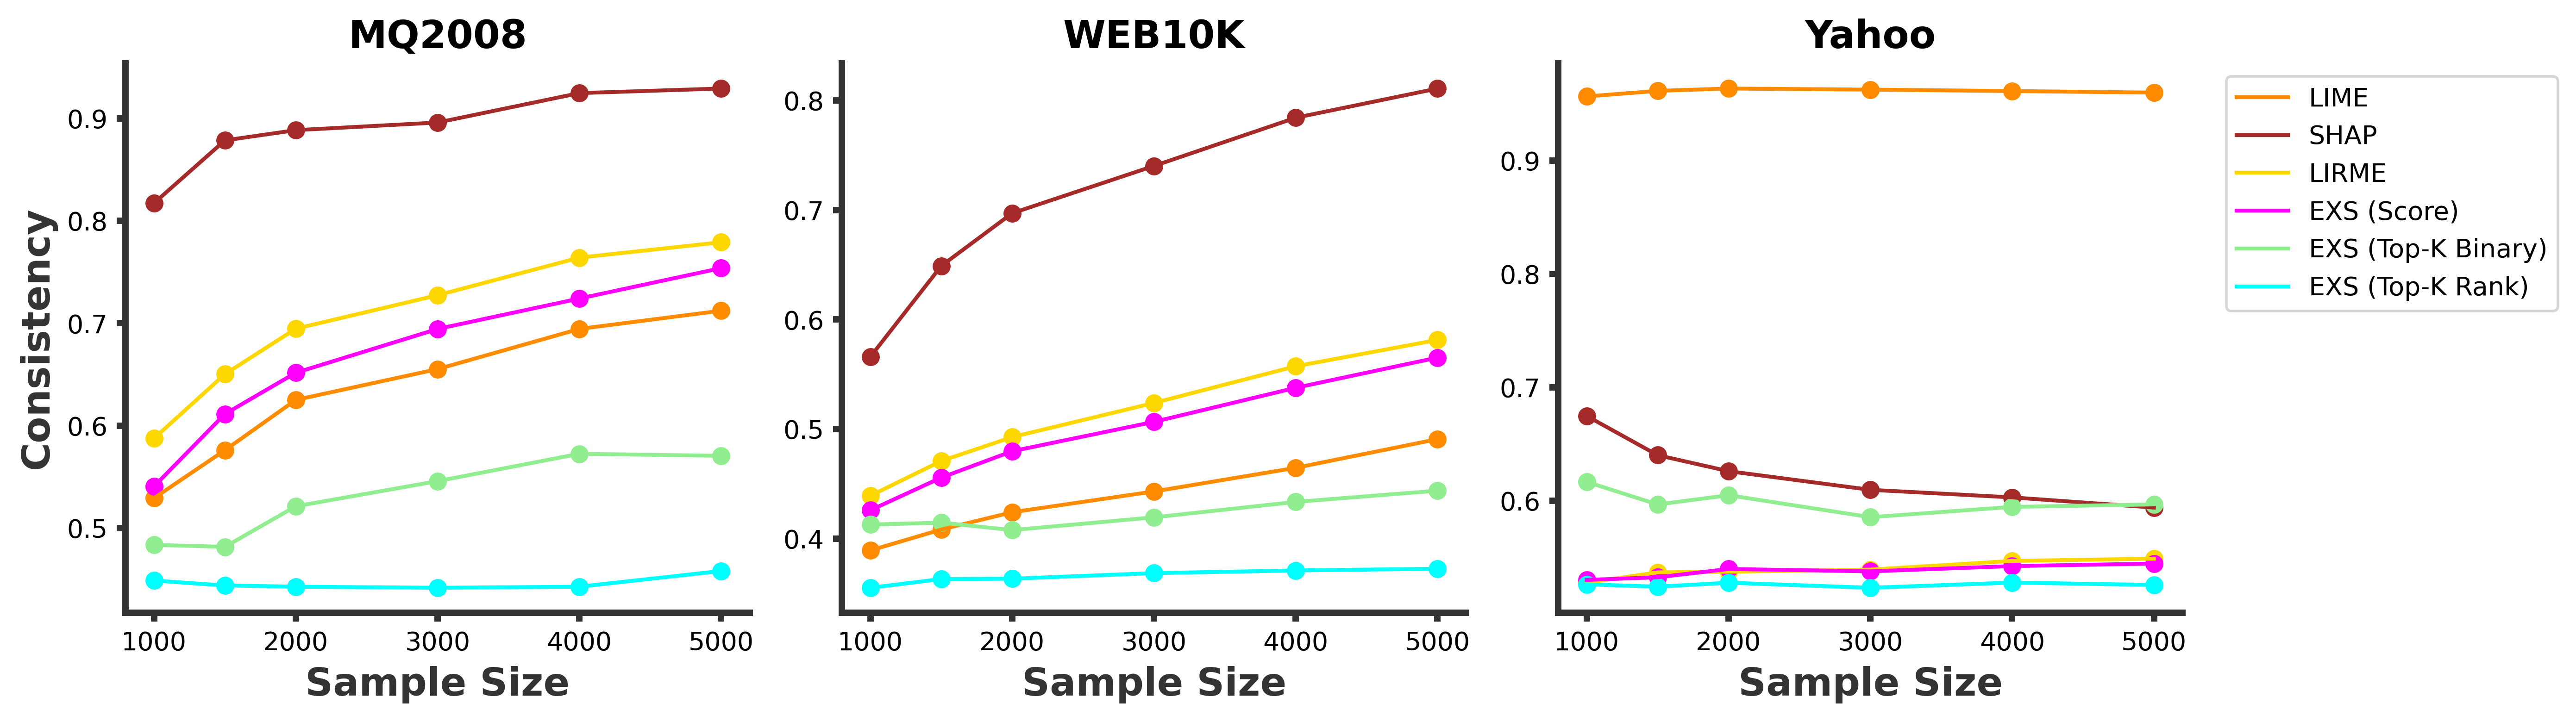

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), dpi=400, sharex=True)

for j in range(len(DATASET_NAMES)):
    DATASET_NAME = DATASET_NAMES[j]
    result = {}
    colors = []
    
    for p in pointwise_exp: 
       result[p] = []
    
    for i in range(len(e_sample_sizes) - 1):
        exps_1 = pickle.load( open( f"./result/{DATASET_NAME}_consistency_pointwise_exps_{e_sample_sizes[i]}.p", "rb" ) )
        exps_2 = pickle.load( open( f"./result/{DATASET_NAME}_consistency_pointwise_exps_{e_sample_sizes[i + 1]}.p", "rb" ) )
        
        for p in pointwise_exp: 
            colors.append(color_list[p])
            temp_0 = []
            for key in exps_1.keys():
                temp = []
                for k in range(len(exps_1[key][p])):
                    #temp.append(kendalltau(exps_1[key][p][k], exps_2[key][p][k]).statistic)
                    temp.append(jaccard(exps_1[key][p][k], exps_2[key][p][k], top_k = int(exps_1[key][p][k].shape[0] * 0.5)))
                    
                temp_0.append(np.mean(temp))
            result[p].append(np.mean(temp_0))
    for r in result.keys():
        ax[j].plot([1000, 1500, 2000, 3000, 4000, 5000], result[r], label=exp_names_figure[r], c=color_list[r])
        ax[j].scatter([1000, 1500, 2000, 3000, 4000, 5000], result[r], c=color_list[r])
    ax[j] = process_ax(ax[j])

ax[0].set_xlabel('Sample Size')
ax[0].set_ylabel('Consistency')
ax[0].set_title('MQ2008', fontsize = 15, fontweight='bold')
ax[1].set_xlabel('Sample Size')
ax[1].set_title('WEB10K', fontsize = 15, fontweight='bold')
ax[2].set_xlabel('Sample Size')
ax[2].set_title('Yahoo', fontsize = 15, fontweight='bold')
ax[2].legend(bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig(f'./consistency_pointwise.pdf')